In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline
# Make a neural network architecture
import keras
from keras.models import Sequential
from keras.layers import Dense

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def normalize(u,mean,std):
    unorm = (u - mean) / std  # Mean of 0.0 and variance of 1.0
    return unorm

In [3]:
def load_data(filename,data_size):
    #Loading data from Tecplot file (check number of skiprows) - no tecplot header
    fine_data = np.loadtxt(filename)

    # Store in numpy array
    vort_fc= np.arange((data_size + 1)* (data_size + 1), dtype='double').reshape(data_size + 1, data_size + 1)
    vort_cs = np.arange((data_size + 1) * (data_size + 1), dtype='double').reshape(data_size + 1, data_size + 1)

    iter = 0
    for j in range(0, data_size + 1):
        for i in range(0, data_size + 1):
            vort_fc[i, j] = fine_data[iter, 0]
            vort_cs[i, j] = fine_data[iter, 1]
            iter = iter + 1

    vort_fc_per = np.arange((data_size) * (data_size), dtype='double').reshape(data_size, data_size)
    vort_cs_per = np.arange((data_size) * (data_size), dtype='double').reshape(data_size, data_size)

    for j in range(0, data_size):
        for i in range(0, data_size):
            vort_fc_per[i, j] = vort_fc[i, j]
            vort_cs_per[i, j] = vort_cs[i, j]
            
    #Normalizing inputs to mean of 0.0 and variance of 1.0
    vort_fc_mean = np.mean(vort_fc_per)
    vort_fc_std = np.std(vort_fc_per)

    vort_fc_per = normalize(vort_fc_per, vort_fc_mean, vort_fc_std)
    vort_cs_per = normalize(vort_cs_per, vort_fc_mean, vort_fc_std)


    return [vort_fc_per, vort_cs_per]

In [4]:
def make_training_data(data_dict, data_size, max_iter):

    stencil_matrix = np.zeros((max_iter,9),dtype='double')
    source_matrix = np.zeros((max_iter, 1), dtype='double')

    global seed_val
    np.random.seed(seed_val)

    for iter in range(0,max_iter):
        i = np.random.randint(1, data_size-1)
        j = np.random.randint(1, data_size-1)

        sub_iter = 0
        #Inputs are \bar{omega} 
        stencil_matrix[iter, sub_iter + 0] = data_dict[0][i, j]
        stencil_matrix[iter, sub_iter + 1] = data_dict[0][i, j + 1]
        stencil_matrix[iter, sub_iter + 2] = data_dict[0][i, j - 1]
        stencil_matrix[iter, sub_iter + 3] = data_dict[0][i + 1, j]
        stencil_matrix[iter, sub_iter + 4] = data_dict[0][i + 1, j + 1]
        stencil_matrix[iter, sub_iter + 5] = data_dict[0][i + 1, j - 1]
        stencil_matrix[iter, sub_iter + 6] = data_dict[0][i - 1, j]
        stencil_matrix[iter, sub_iter + 7] = data_dict[0][i - 1, j + 1]
        stencil_matrix[iter, sub_iter + 8] = data_dict[0][i - 1, j - 1]

        #Outputs are \omega^c
        source_matrix[iter, 0] = data_dict[1][i, j]

        #You can flip the data_dict[index] for training other map
    return [stencil_matrix, source_matrix]

In [5]:
data_size = 256
#Test data generation
seed_val = 1
#Large unnormalized databank generated
max_iter = 30000#A maximum of 256*256 is possible - choose a number lesser than it for random sampling

t_init = 0
t_end = 4

for time in range(t_init,t_end+1):
    filename = r'Source.' + str(500+time)
    data_dict = load_data(filename, data_size)

    if time == t_init:
        training_dict = make_training_data(data_dict, data_size, max_iter)

    else:
        training_dict_temp = make_training_data(data_dict, data_size, max_iter)

        training_dict[0] = np.concatenate((training_dict[0],training_dict_temp[0]),axis=0)
        training_dict[1] = np.concatenate((training_dict[1],training_dict_temp[1]),axis=0)


In [6]:
import keras.backend as K
def coeff_determination(y_true, y_pred):
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [7]:
X=training_dict[0]
y=training_dict[1]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=0.2,random_state = 0)

# Different architecture of artificial neural networks

In [9]:
def network_1layer():
    NN_reg = Sequential()
    NN_reg.add(Dense(input_dim = 9, units = 100, activation = 'relu'))
    NN_reg.add(Dense(units = 1, activation = 'linear'))
    NN_reg.compile(loss='mean_squared_error', optimizer='adam')
    return NN_reg

def network_3layer():
    NN_reg = Sequential()
    NN_reg.add(Dense(input_dim = 9, units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 1, activation = 'linear'))
    NN_reg.compile(loss='mean_squared_error', optimizer='adam')
    return NN_reg

def network_5layer():
    NN_reg = Sequential()
    NN_reg.add(Dense(input_dim = 9, units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 1, activation = 'linear'))
    NN_reg.compile(loss='mean_squared_error', optimizer='adam')
    return NN_reg

def network_7layer():
    NN_reg = Sequential()
    NN_reg.add(Dense(input_dim = 9, units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 100, activation = 'relu'))
    NN_reg.add(Dense(               units = 1, activation = 'linear'))
    NN_reg.compile(loss='mean_squared_error', optimizer='adam')
    return NN_reg

def network_1layer_10N():
    NN_reg = Sequential()
    NN_reg.add(Dense(input_dim = 9, units = 10, activation = 'relu'))
    NN_reg.add(Dense(units = 1, activation = 'linear'))
    NN_reg.compile(loss='mean_squared_error', optimizer='adam')
    return NN_reg

def network_1layer_50N():
    NN_reg = Sequential()
    NN_reg.add(Dense(input_dim = 9, units = 10, activation = 'relu'))
    NN_reg.add(Dense(units = 1, activation = 'linear'))
    NN_reg.compile(loss='mean_squared_error', optimizer='adam')
    return NN_reg

def network_1layer_150N():
    NN_reg = Sequential()
    NN_reg.add(Dense(input_dim = 9, units = 10, activation = 'relu'))
    NN_reg.add(Dense(units = 1, activation = 'linear'))
    NN_reg.compile(loss='mean_squared_error', optimizer='adam')
    return NN_reg

# Training the artificial neural networks

In [10]:
NN_reg1_layer = network_1layer()
NN_reg1_layer_10N = network_1layer_10N()
NN_reg1_layer_50N = network_1layer_50N()
NN_reg1_layer_150N = network_1layer_150N()
NN_reg3_layer = network_3layer()
NN_reg5_layer = network_5layer()
NN_reg7_layer = network_7layer()
NN_reg1_layer.fit(X_train,y_train,epochs=100,batch_size=1024,verbose=0)
NN_reg1_layer_10N.fit(X_train,y_train,epochs=100,batch_size=1024,verbose=0)
NN_reg1_layer_50N.fit(X_train,y_train,epochs=100,batch_size=1024,verbose=0)
NN_reg1_layer_150N.fit(X_train,y_train,epochs=100,batch_size=1024,verbose=0)
NN_reg3_layer.fit(X_train,y_train,epochs=100,batch_size=1024,verbose=0)
NN_reg5_layer.fit(X_train,y_train,epochs=100,batch_size=1024,verbose=0)
NN_reg7_layer.fit(X_train,y_train,epochs=100,batch_size=1024,verbose=0)

In [11]:
y_pred1_layer_train=NN_reg1_layer.predict(X_train)
y_pred1_layer_test=NN_reg1_layer.predict(X_test)
y_pred1_layer_10N_train=NN_reg1_layer_10N.predict(X_train)
y_pred1_layer_10N_test =NN_reg1_layer_10N.predict(X_test)
y_pred1_layer_50N_train=NN_reg1_layer_50N.predict(X_train)
y_pred1_layer_50N_test =NN_reg1_layer_50N.predict(X_test)
y_pred1_layer_150N_train=NN_reg1_layer_150N.predict(X_train)
y_pred1_layer_150N_test =NN_reg1_layer_150N.predict(X_test)
y_pred3_layer_train=NN_reg3_layer.predict(X_train)
y_pred3_layer_test=NN_reg3_layer.predict(X_test)
y_pred5_layer_train=NN_reg5_layer.predict(X_train)
y_pred5_layer_test=NN_reg5_layer.predict(X_test)
y_pred7_layer_train=NN_reg7_layer.predict(X_train)
y_pred7_layer_test=NN_reg7_layer.predict(X_test)

# Computing the mean squared error

In [12]:
MSE1_layer_train=mean_squared_error(y_pred1_layer_train,y_train)
MSE1_layer_10N_train =mean_squared_error(y_pred1_layer_10N_train ,y_train)
MSE1_layer_50N_train =mean_squared_error(y_pred1_layer_50N_train ,y_train)
MSE1_layer_150N_train=mean_squared_error(y_pred1_layer_150N_train,y_train)
MSE3_layer_train=mean_squared_error(y_pred3_layer_train,y_train)
MSE5_layer_train=mean_squared_error(y_pred5_layer_train,y_train)
MSE7_layer_train=mean_squared_error(y_pred7_layer_train,y_train)
MSE1_layer_test=mean_squared_error(y_pred1_layer_test,y_test)
MSE1_layer_10N_test =mean_squared_error(y_pred1_layer_10N_test ,y_test)
MSE1_layer_50N_test =mean_squared_error(y_pred1_layer_50N_test ,y_test)
MSE1_layer_150N_test=mean_squared_error(y_pred1_layer_150N_test,y_test)
MSE3_layer_test=mean_squared_error(y_pred3_layer_test,y_test)
MSE5_layer_test=mean_squared_error(y_pred5_layer_test,y_test)
MSE7_layer_test=mean_squared_error(y_pred7_layer_test,y_test)

# Comparing the mean squared error in predictions by different ANN

Text(0,0.5,'Mean Square Error')

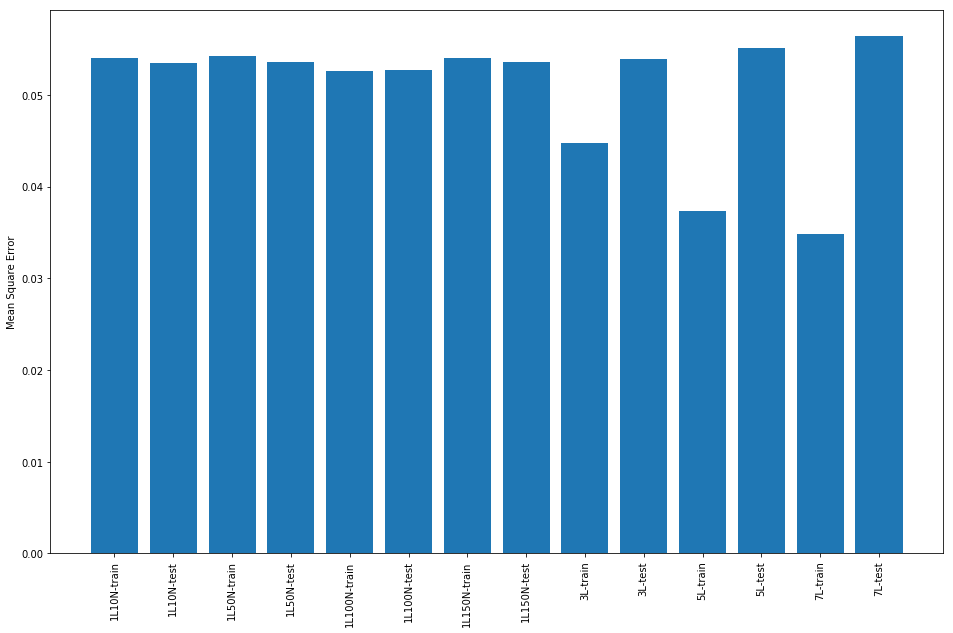

In [13]:
fig=plt.figure(figsize=(16,10))
myplt = [MSE1_layer_10N_train, MSE1_layer_10N_test,MSE1_layer_50N_train, MSE1_layer_50N_test,  MSE1_layer_train, MSE1_layer_test,MSE1_layer_150N_train, MSE1_layer_150N_test, MSE3_layer_train, MSE3_layer_test,MSE5_layer_train, MSE5_layer_test,MSE7_layer_train, MSE7_layer_test]
plt.bar(range(len(myplt)), myplt)
plt.xticks(range(len(myplt)), ('1L10N-train', '1L10N-test','1L50N-train', '1L50N-test','1L100N-train', '1L100N-test','1L150N-train', '1L150N-test','3L-train','3L-test', '5L-train' , '5L-test', '7L-train','7L-test'),rotation='vertical')
plt.ylabel('Mean Square Error')

# Linear Regression

In [16]:
#Training the model#Traini 
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)
LR_prediction_train=lr.predict(X_train)
LR_prediction_test=lr.predict(X_test)
LR_MRS_train=mean_squared_error(LR_prediction_train,y_train)
LR_MRS_test=mean_squared_error(LR_prediction_test,y_test)

# Random Forest

In [28]:
#Training the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
rf = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=10, min_samples_split=2, 
                           min_samples_leaf=4, min_weight_fraction_leaf=0.0, max_features='auto', 
                           max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                           bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, 
                           warm_start=False)
rf.fit(X_train,y_train)
#Make predictions on the training and test sets
RF_prediction_test = rf.predict(X_test)
RF_prediction_train = rf.predict(X_train)
RF_MRS_train=mean_squared_error(RF_prediction_train,y_train)
RF_MRS_test=mean_squared_error(RF_prediction_test,y_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


# Decision Tree

In [32]:
#Training the model
from sklearn import tree
dt = tree.DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=10, 
                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                min_impurity_split=None, presort=False)
dt.fit(X_train,y_train)
#Make predictions on the training and test sets
DT_prediction_test = dt.predict(X_test)
DT_prediction_train = dt.predict(X_train)
#Report the errors in prediction on the train and the test set
DT_MRS_train=mean_squared_error(DT_prediction_train,y_train)
DT_MRS_test=mean_squared_error(DT_prediction_test,y_test)

# Inter-comparison of different ML algorithms

Text(0,0.5,'Mean Square Error')

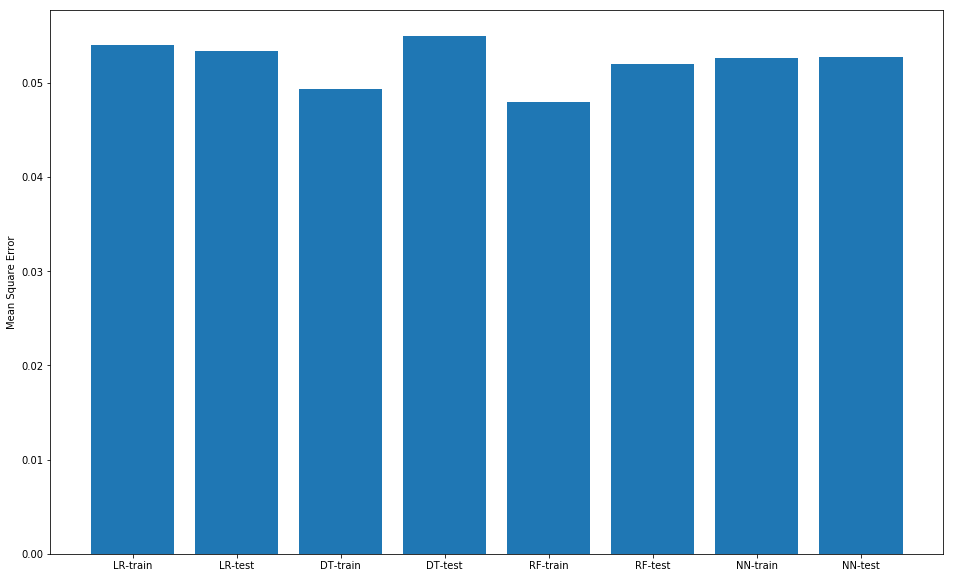

In [33]:
fig=plt.figure(figsize=(16,10))
myplt = [LR_MRS_train, LR_MRS_test,DT_MRS_train, DT_MRS_test, RF_MRS_train, RF_MRS_test, MSE1_layer_train, MSE1_layer_test]
plt.bar(range(len(myplt)), myplt)
plt.xticks(range(len(myplt)), ('LR-train', 'LR-test','DT-train','DT-test', 'RF-train' , 'RF-test','NN-train','NN-test'))
plt.ylabel('Mean Square Error')